In [1]:
"""
@authors: faurand, chardes, ehagensieker
"""
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import tqdm
import pprint

# in a notebook, load the tensorboard extension, not needed for scripts
%load_ext tensorboard

#load the mnist dataset
(train_ds, test_ds) = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)


2022-12-04 18:58:46.043065: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-04 18:58:46.043135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-04 18:58:46.043143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


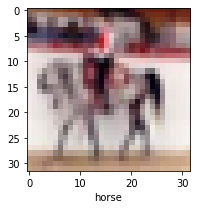

In [2]:
train = list(train_ds)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(3,3))
plt.imshow(train[0][0])
plt.xlabel(class_names[int(train[0][1])])
plt.show()

In [3]:
def prepare_data(batch_size, data): 
  '''
  prepare the dataset to have one-hot-vectors and values between -1 and 1
  '''
  data = data.map(lambda img, target: (tf.cast(img, tf.float32), tf.cast(target,tf.int32)))
  data = data.map(lambda img, target: ((img/128.)-1.0, target))
  data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  
  data = data.cache()
  data = data.shuffle(1000)
  data = data.batch(batch_size)
  data = data.prefetch(20)

  return data


In [4]:
from tensorflow.keras.layers import Dense

class BasicConv(tf.keras.Model):
  '''
  create a small network with 2 blocks each having 2 layers and starting with 32 filters in the first layer
  '''
  def __init__(self,optimizer = tf.keras.optimizers.Adam()):
    super(BasicConv, self).__init__()

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    self.metrics_list = [ tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
    ]

    #original input size is 32*32, we have 32 as number of filters
    self.l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')

    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    #after pooling the size is reduced to 16*16
    self.l3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')

    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    # last layer is a dense layer with softmax activation 
    self.out = tf.keras.layers.Dense(10, activation = 'softmax')

  def call(self, x): 
    x = self.l1(x)
    x = self.l2(x)
    x = self.pooling(x)
    x = self.l3(x)
    x = self.l4(x)
    x = self.global_pool(x)
    x = self.out(x)

    return x


  @property
  def metrics(self):
    return self.metrics_list


  def reset_metric(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

In [5]:
from tensorflow.keras.layers import Dense

class BasicConvFilter1(tf.keras.Model):
  '''
  create a small network with 2 blocks each having 2 layers and starting with 64 filters in the first layer
  '''
  def __init__(self,optimizer = tf.keras.optimizers.Adam()):
    super(BasicConvFilter1, self).__init__()

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    self.metrics_list = [ tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
    ]

    #original input size is 32*32, we have 32 as number of filters
    self.l1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')

    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    #after pooling the size is reduced to 16*16
    self.l3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l4 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')

    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    # last layer is a dense layer with softmax activation 
    self.out = tf.keras.layers.Dense(10, activation = 'softmax')

  def call(self, x): 
    x = self.l1(x)
    x = self.l2(x)
    x = self.pooling(x)
    x = self.l3(x)
    x = self.l4(x)
    x = self.global_pool(x)
    x = self.out(x)

    return x


  @property
  def metrics(self):
    return self.metrics_list


  def reset_metric(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

In [6]:
from tensorflow.keras.layers import Dense

class BasicConvFilter2(tf.keras.Model):
  '''
  create a small network with 2 blocks each having 2 layers and starting with 16 filters in the first layer
  '''
  def __init__(self,optimizer = tf.keras.optimizers.Adam()):
    super(BasicConvFilter2, self).__init__()

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    self.metrics_list = [ tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
    ]

    #original input size is 32*32, we have 32 as number of filters
    self.l1 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l2 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu')

    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    #after pooling the size is reduced to 16*16
    self.l3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l4 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')

    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    # last layer is a dense layer with softmax activation 
    self.out = tf.keras.layers.Dense(10, activation = 'softmax')

  def call(self, x): 
    x = self.l1(x)
    x = self.l2(x)
    x = self.pooling(x)
    x = self.l3(x)
    x = self.l4(x)
    x = self.global_pool(x)
    x = self.out(x)

    return x


  @property
  def metrics(self):
    return self.metrics_list


  def reset_metric(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

In [7]:
from tensorflow.keras.layers import Dense

class BasicConvDeep(tf.keras.Model):
  '''
  create a deeper network with 4 blocks each having 2 layers and starting with 32 filters in the first layer
  '''

  def __init__(self,optimizer = tf.keras.optimizers.Adam()):
    super(BasicConvDeep, self).__init__()

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    self.metrics_list = [ tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
    ]

    #original input size is 32*32, we have 32 as number of filters
    self.l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')

    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    #after pooling the size is reduced to 16*16
    self.l3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')

    self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.l5 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l6 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')

    self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.l7 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')
    self.l8 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')

    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    # last layer is a dense layer with softmax activation 
    self.out = tf.keras.layers.Dense(10, activation = 'softmax')

  def call(self, x): 
    x = self.l1(x)
    x = self.l2(x)
    x = self.pooling(x)
    x = self.l3(x)
    x = self.l4(x)
    x = self.pooling1(x)
    x = self.l5(x)
    x = self.l6(x)
    x = self.pooling2(x)
    x = self.l7(x)
    x = self.l8(x)
    x = self.global_pool(x)
    x = self.out(x)

    return x


  @property
  def metrics(self):
    return self.metrics_list


  def reset_metric(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

In [8]:
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filter): 
    super(DenselyConnectedCNNLayer, self).__init__()

    self.conv = tf.keras.layers.Conv2D(filters = num_filter, kernel_size = 3, padding = "same", activation = "relu")

  def call(self,x): 
    c = self.conv(x)
    #concatenate at last layer - get long stack of all earlier layer
    x = tf.concat((x,c), axis = -1)
    return x


class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  #take all conv layers and create a block we take for one convolution
  def __init__(self, num_filters, layers):
    super(DenselyConnectedCNNBlock, self).__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]

  def call(self, x): 
    #take input and pump it through all layers we have 
    for l in self.layers:
      x = l(x)
      return x


class DenselyConnectedCNN(tf.keras.Model):
  def __init__(self, optimizer = tf.keras.optimizers.Adam()):
    super(DenselyConnectedCNN, self).__init__()

    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    self.metrics_list = [ tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
    ]

    #4 layers with each of 24 kernels -> get 4 layer in 28*28 resolution 
    self.denseblock1 = DenselyConnectedCNNBlock(24,4)
    #go down to 14*14
    self.pooling1 = tf.keras.layers.MaxPooling2D()

    self.denseblock2 = DenselyConnectedCNNBlock(24,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D()

    self.denseblock3 = DenselyConnectedCNNBlock(24,4)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self, x):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

  @property
  def metrics(self):
    return self.metrics_list


  def reset_metric(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}


dense_model = DenselyConnectedCNN()


In [9]:
class ResidualConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters, optimizer = tf.keras.optimizers.Adam()):
    super(ResidualConnectedCNNLayer, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    #residual connection 
    x = c+x
    return x

class ResidualConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, depth, layers):
    super(ResidualConnectedCNNBlock, self).__init__()
    #depth increases in the end of the network (cannot add them with different sizes)
    #specify the depth such that they get the same depth 
    self.deeper_layer = tf.keras.layers.Conv2D(filters=depth, kernel_size=3, padding='same', activation='relu')
    #list with many residual connected cnn layer
    self.layers = [ResidualConnectedCNNLayer(depth) for _ in range(layers)]

  def call(self, x):
    #bring it to the correct depth 
    x = self.deeper_layer(x)
    for layer in self.layers:
      x = layer(x)
    return x


class ResidualConnectedCNN(tf.keras.Model):
  def __init__(self, optimizer = tf.keras.optimizers.Adam()):
    super(ResidualConnectedCNN, self).__init__()
    self.optimizer = optimizer
    self.loss_function = tf.keras.losses.CategoricalCrossentropy()

    self.metrics_list = [ tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
    ]
    self.residualblock1 = ResidualConnectedCNNBlock(24,4)
    self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.residualblock2 = ResidualConnectedCNNBlock(48,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.residualblock3 = ResidualConnectedCNNBlock(96,4)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    
    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self,x):
    x = self.residualblock1(x)
    x = self.pooling1(x)
    x = self.residualblock2(x)
    x = self.pooling2(x)
    x = self.residualblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

  @property
  def metrics(self):
    return self.metrics_list


  def reset_metric(self):
    for metric in self.metrics: 
      metric.reset_states()

  @tf.function 
  def train_step(self, data):
    x, t = data
    #print(x.shape)

    with tf.GradientTape() as tape:
      output = self(x, training = True)
      loss = self.loss_function(t, output)
    
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    self.metrics[0].update_state(loss)
    
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}

  @tf.function
  def test_step(self, data):
    x, t = data

    output = self(x, training = False)
    loss = self.loss_function(t, output)

    self.metrics[0].update_state(loss)
    for metric in self.metrics[1:]:
          metric.update_state(t,output)

    return {metric.name: metric.result() for metric in self.metrics}


resnet = ResidualConnectedCNN()

In [10]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer): 
  '''
  create the training loop where the model is trained on the train dataset and afterwards tested on the validation dataset
  '''
  hist = {"train_loss":[],"train_acc":[],"test_loss":[], "test_acc":[]}
  #iterate over given amount of epochs
  for epoch in range(epochs): 
    print(f"Epoch {epoch}: ")

    #train on all batches of the training data
    for data in tqdm.tqdm(train_ds, position = 0, leave = True):

      metrics = model.train_step(data)

      with train_summary_writer.as_default(): 
        for metric in model.metrics: 
          tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

    # print the metrics and add to history element
    for key, value in metrics.items():
      hist[f"train_{key}"].append(value.numpy())
      print(f"train_{key}: {value.numpy()}")

    #reset metric 
    model.reset_metrics()
  
    #evaluation on validation set
    for data in val_ds:
      metrics = model.test_step(data)

      with val_summary_writer.as_default():
        for metric in model.metrics:
          tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
      
    # print the metrics and add to history element
    for key, value in metrics.items():
      hist[f"test_{key}"].append(value.numpy())
      print(f"test_{key}: {value.numpy()}")

    #reset metric
    model.reset_metric()
    print("\n")
    
  return hist

In [11]:
def create_summary_writers(config_name):
  '''
  create the summary writer to have access to the metrics of the model 
  '''
  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

  train_log_path = f"logs/submission/{config_name}/{current_time}/train"
  val_log_path = f"logs/submission/{config_name}/{current_time}/val"

  # log writer
  train_summary_writer = tf.summary.create_file_writer(train_log_path)
  val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
  return train_summary_writer, val_summary_writer

In [12]:
import matplotlib.pyplot as plt 
def run(model,num_epochs=15,save=True,load=False,config_name = f'RUN'):
  '''
  run the model and specify the number of epochs, batch_size and prepare the training and testing data
  '''

  ### Hyperparameters
  num_epochs = num_epochs
  batch_size = 32
  train = prepare_data(batch_size,train_ds)
  test = prepare_data(batch_size,test_ds)
  
  train_summary_writer, val_summary_writer = create_summary_writers(config_name)
  if load:
    model.load_weights(f"saved_model_{config_name}");

  hist = training_loop(model,train,test,num_epochs,train_summary_writer, val_summary_writer)
  
  if save:
    model.save_weights(f"saved_model_{config_name}", save_format="tf")

 
  fig, ax = plt.subplots(1,2, figsize=(10,10))

  ax[0].plot(hist['train_acc'], label='train accuracy')
  ax[0].plot(hist['test_acc'], label='test accuracy')
  ax[0].legend()

  ax[1].plot(hist['train_loss'], label='train loss')
  ax[1].plot(hist['test_loss'], label='test loss')
  ax[1].legend();

In [13]:
myMod1 = BasicConv(tf.keras.optimizers.SGD(learning_rate=0.001, momentum = 0.9))
print("BasicConv, optimizer=SGD, learning_rate=0.001, momentum=0.9\n")
run(myMod1,num_epochs=5,config_name=f'BASIC1')

BasicConv, optimizer=SGD, learning_rate=0.001, momentum=0.9

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 0: 


  0%|          | 0/1563 [00:00<?, ?it/s]2022-12-04 18:59:00.300313: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-12-04 18:59:00.300392: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:621 : UNIMPLEMENTED: DNN library is not found.
2022-12-04 18:59:00.615374: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
  0%|          | 0/1563 [00:01<?, ?it/s]


UnimplementedError: Graph execution error:

Detected at node 'basic_conv/conv2d_27/Relu' defined at (most recent call last):
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_15678/76847003.py", line 3, in <module>
      run(myMod1,num_epochs=5,config_name=f'BASIC1')
    File "/tmp/ipykernel_15678/257391540.py", line 17, in run
      hist = training_loop(model,train,test,num_epochs,train_summary_writer, val_summary_writer)
    File "/tmp/ipykernel_15678/287163848.py", line 13, in training_loop
      metrics = model.train_step(data)
    File "/tmp/ipykernel_15678/2657552222.py", line 59, in train_step
      output = self(x, training = True)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_15678/2657552222.py", line 33, in call
      x = self.l1(x)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'basic_conv/conv2d_27/Relu'
DNN library is not found.
	 [[{{node basic_conv/conv2d_27/Relu}}]] [Op:__inference_train_step_101204]

In [ ]:
myMod1 = BasicConv(tf.keras.optimizers.SGD(learning_rate=0.001, momentum = 0.9))
run(myMod1,num_epochs=1,load=True,config_name=f'BASIC1')

In [ ]:
myMod2 = BasicConv(tf.keras.optimizers.Adam(learning_rate=0.001))
print("\nBasicConv, optimizer=Adam, learning_rate=0.001\n")
run(myMod2,num_epochs=10,config_name=f'BASIC2')

In [ ]:
print("saved after epoch 10: ")
run(myMod2,num_epochs=10,load=True,config_name=f'BASIC2')

In [ ]:
myMod3 = BasicConv(tf.keras.optimizers.RMSprop(learning_rate=0.001))
print("BasicConv, optimizer=RMSProp, learning_rate=0.001\n")
run(myMod3,num_epochs=2,save=False)

In [ ]:
myMod4 = BasicConv(tf.keras.optimizers.Adagrad(learning_rate=0.001))
print("\nBasicConv, optimizer=Adagrad, learning_rate=0.001\n")
run(myMod4,num_epochs=5,save=False)


In [ ]:
myMod5 = BasicConv(tf.keras.optimizers.SGD(learning_rate=0.001))

print("\BasicConv, optimizer=SGD, learning_rate=0.001\n")
run(myMod5,num_epochs=5,save=False)

In [ ]:
myMod6 = BasicConvFilter1(tf.keras.optimizers.SGD(learning_rate=0.001, momentum = 0.9))
myMod7 = BasicConvFilter1(tf.keras.optimizers.Adam(learning_rate=0.001))

print("BasicConvFilter1 with a higher number of filters, optimizer=SGD, learning_rate=0.001, momentum=0.9\n")
run(myMod6,num_epochs=5,save=False)
print("\nBasicConvFilter1 with a higher number of filters, optimizer=Adam, learning_rate=0.001\n")
run(myMod7,num_epochs=5,save=False)

In [ ]:
#myMod8 = BasicConvFilter2(tf.keras.optimizers.SGD(learning_rate=0.001, momentum = 0.9))
myMod9 = BasicConvFilter2(tf.keras.optimizers.Adam(learning_rate=0.001))

print("BasicConvFilter2 with a lower number of filters, optimizer=SGD, learning_rate=0.001, momentum=0.9\n")
run(myMod9,num_epochs=10,config_name=f'BASICFILTER2_ADAM')
# print("\nBasicConvFilter2 with a lower number of filters, optimizer=Adam, learning_rate=0.001\n")
# run(myMod9)

In [ ]:
myMod9 = BasicConvFilter2(tf.keras.optimizers.Adam(learning_rate=0.001))

print("saved after epoch 15")
run(myMod9,num_epochs=10,load=True,config_name=f'BASICFILTER2_ADAM')

In [ ]:
#myMod10 = BasicConvDeep(tf.keras.optimizers.SGD(learning_rate=0.001, momentum = 0.9))
myMod11 = BasicConvDeep(tf.keras.optimizers.Adam(learning_rate=0.001))

# print("BasicConvDeep with a deeper network, optimizer=SGD, learning_rate=0.001, momentum=0.9\n")
# run(myMod10)
print("\nBasicConvDeep with a deeper network, optimizer=Adam, learning_rate=0.001\n")
run(myMod11,num_epochs=10,config_name=f'BASICDEEP_ADAM')

In [ ]:
print("after 10 epochs")
run(myMod11,num_epochs=5,load=True,config_name=f'BASICDEEP_ADAM')

In [ ]:
myMod12 = ResidualConnectedCNN(tf.keras.optimizers.SGD(learning_rate=0.001))

print("Residual Convolutional Network, optimizer=SGD, learning_rate=0.001")
run(myMod12,num_epochs=5,save=False)

In [ ]:
myMod13 = DenselyConnectedCNN(tf.keras.optimizers.SGD(learning_rate=0.001))

print("Densely Connected Convolutional Network, optimizer=SGD\n")
run(myMod13,num_epochs=5)



In [ ]:
run(myMod13,num_epochs=5,load=True)

In [ ]:
%tensorboard --logdir logs/submission/